### Load the Dataset

We start by loading the `Uber Customer Reviews` dataset. This dataset contains over 12,000 user reviews scraped from the Google Play Store, which we will use for sentiment analysis and opinion mining.

In [ ]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_scheduler
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_recall_fscore_support
from sklearn.utils.class_weight import compute_class_weight
import torch
import numpy as np

# Load the dataset
df = pd.read_csv("/content/uber_reviews_without_reviewid.csv")


In [ ]:
df.head()

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,User_0,NaN,Good,5,0,4.556.10005,2024-12-18 17:17:19,NaN,NaN,4.556.10005
1,User_1,NaN,Nice,5,0,4.556.10005,2024-12-18 17:17:17,NaN,NaN,4.556.10005
2,User_2,NaN,Very convenient,5,0,4.532.10001,2024-12-18 17:09:42,NaN,NaN,4.532.10001
3,User_3,NaN,Good,4,0,4.556.10005,2024-12-18 17:08:27,NaN,NaN,4.556.10005
4,User_4,NaN,exllence,5,0,4.556.10005,2024-12-18 17:08:16,NaN,NaN,4.556.10005


### Text Preprocessing

To prepare the reviews for machine learning and NLP tasks, we clean the text using the following steps:

1. Convert all text to lowercase.
2. Remove punctuation, numbers, and special characters.
3. Remove common stopwords (e.g., "the", "and", "is").
4. Apply lemmatization to reduce words to their base forms (e.g., "running" → "run").

We will use **NLTK** for stopword removal and lemmatization.

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define the preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercase
    text = re.sub(r'[^a-z\s]', '', text)  # Remove punctuation and numbers
    tokens = [word for word in text.split() if word not in stop_words]  # Remove stopwords
    lemmatized = [lemmatizer.lemmatize(token) for token in tokens]  # Lemmatization
    return " ".join(lemmatized)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
# Apply the text cleaning function to the 'content' column
df['cleaned_content'] = df['content'].apply(preprocess_text)

# Display original vs. cleaned text for first 10 reviews
df[['content', 'cleaned_content']].head(20)

,content,cleaned_content
0,Good,good
1,Nice,nice
2,Very convenient,convenient
3,Good,good
4,exllence,exllence
5,Michelle was a very friendly and personable pe...,michelle friendly personable person polite
6,Bast price pr car available,bast price pr car available
7,Good service,good service
8,Awesome,awesome
9,Nice 🙂🙂🙂🙂🙂,nice


### Create Sentiment Labels

We convert the `score` (1–5) into sentiment categories to train classification models:

- **1 or 2** → Negative  
- **3** → Neutral  
- **4 or 5** → Positive

This new categorical label will be stored in a column called `sentiment_label`.


In [ ]:
# Function to map numerical scores to sentiment categories
def label_sentiment(score):
    if score <= 2:
        return "negative"
    elif score == 3:
        return "neutral"
    else:
        return "positive"

# Apply the mapping to create a new column
df['sentiment_label'] = df['score'].apply(label_sentiment)

# Display counts of each sentiment class
df['sentiment_label'].value_counts()

,count
sentiment_label,
positive,8732
negative,2935
neutral,333


### Visualize the Sentiment Distribution

To understand the overall sentiment of the Uber reviews, we visualize the distribution of sentiment labels (positive, neutral, negative) using a bar chart. This gives us an initial understanding of customer satisfaction levels in the dataset.

/tmp/ipython-input-7-3337753781.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='sentiment_label', data=df, palette='pastel')


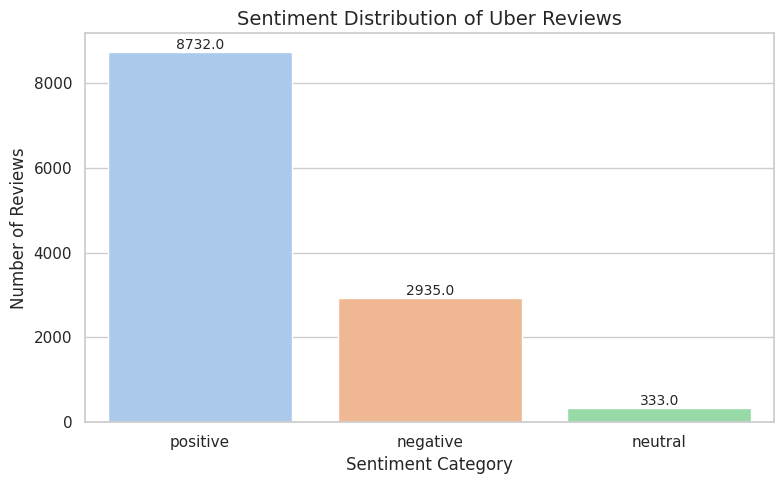

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set plot style
sns.set(style="whitegrid")

# Count sentiment labels
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='sentiment_label', data=df, palette='pastel')
plt.title("Sentiment Distribution of Uber Reviews", fontsize=14)
plt.xlabel("Sentiment Category")
plt.ylabel("Number of Reviews")

# Annotate bars with counts
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height}', (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

### Feature Engineering （Traditional ML）:
For traditional machine learning purpose,  Model Training with Logistic Regression or SVM

To convert the cleaned review text into numerical features suitable for machine learning models, we use **TF-IDF (Term Frequency–Inverse Document Frequency)**. This method highlights words that are important to a particular review but not too common across all reviews.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize the vectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # limit to top 5000 tokens

# Fit and transform the cleaned text
X = vectorizer.fit_transform(df['cleaned_content'])

# Store the labels
y = df['sentiment_label']

# Check the shape of the resulting matrix
X.shape

(12000, 5000)

## 🧠 Train Classical Machine Learning Models

With the TF-IDF feature matrix prepared, we now train and evaluate three traditional machine learning models for sentiment classification:

1. **Logistic Regression**  
2. **Support Vector Machine (SVM)**  
3. **Random Forest Classifier**

Each model will be evaluated using the following performance metrics:

- **Accuracy**: Measures the overall correctness of the model.
- **Precision**: Indicates how many predicted positive instances are truly positive.
- **Recall**: Shows how many actual positive instances the model correctly identified.
- **F1-Score**: Harmonic mean of Precision and Recall, balancing both concerns.

These metrics offer a comprehensive view of each model's performance and support fair benchmarking across models.

Combine the result for the traditional ML Model

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
import pandas as pd

# Vectorize using TF-IDF (use your existing preprocessed column)
vectorizer = TfidfVectorizer(max_features=5000)
X = vectorizer.fit_transform(df['cleaned_content'])
y = df['sentiment_label']

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
}

# K-Fold setup
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Evaluation function
def evaluate_model_cv(name, model, X, y):
    y_pred = cross_val_predict(model, X, y, cv=skf)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted', zero_division=0)
    accuracy = accuracy_score(y, y_pred)
    return {
        'Model': name,
        'Accuracy': round(accuracy, 4),
        'Precision': round(precision, 4),
        'Recall': round(recall, 4),
        'F1-Score': round(f1, 4)
    }

# Collect results
results = []
for name, model in models.items():
    results.append(evaluate_model_cv(name, model, X, y))

# Display as DataFrame
results_df = pd.DataFrame(results)
print(results_df)


                 Model  Accuracy  Precision  Recall  F1-Score
0  Logistic Regression    0.9173     0.8914  0.9173    0.9041
1                  SVM    0.9145     0.8947  0.9145    0.9025
2        Random Forest    0.9016     0.8768  0.9016    0.8890


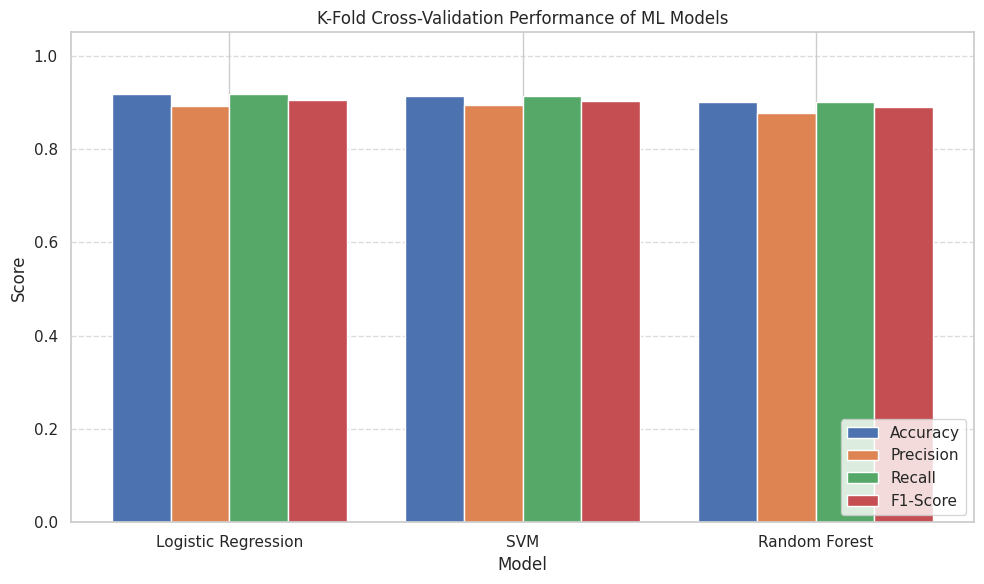

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Prepare values
models = results_df['Model']
x = range(len(models))
width = 0.2

# Extract metric columns
accuracy = results_df['Accuracy']
precision = results_df['Precision']
recall = results_df['Recall']
f1_score = results_df['F1-Score']

# Plotting
plt.figure(figsize=(10, 6))
plt.bar([i - 1.5*width for i in x], accuracy, width, label='Accuracy')
plt.bar([i - 0.5*width for i in x], precision, width, label='Precision')
plt.bar([i + 0.5*width for i in x], recall, width, label='Recall')
plt.bar([i + 1.5*width for i in x], f1_score, width, label='F1-Score')

# Labels and style
plt.xticks(x, models)
plt.ylim(0, 1.05)
plt.xlabel("Model")
plt.ylabel("Score")
plt.title("K-Fold Cross-Validation Performance of ML Models")
plt.legend(loc='lower right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

### Feature Engineering （Deep Learning Models : BiLSTM）

In this step, we convert cleaned text into padded sequences of integers using `Tokenizer`, and encode sentiment labels into numeric values.


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder

# Set vocabulary and sequence length
MAX_VOCAB = 10000     # Limit to the top 10,000 most frequent words
MAX_LENGTH = 100      # Maximum sequence length for padding

# Initialize and fit tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_content'])

# Convert text to integer sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_content'])

# Apply padding to sequences
X_seq = pad_sequences(sequences, maxlen=MAX_LENGTH, padding='post', truncating='post')

# Encode target labels to integers
label_encoder = LabelEncoder()
y_seq = label_encoder.fit_transform(df['sentiment_label'])

# Preview results
print("✅ Feature matrix shape:", X_seq.shape)
print("✅ Sentiment classes:", list(label_encoder.classes_))

✅ Feature matrix shape: (12000, 100)
✅ Sentiment classes: ['negative', 'neutral', 'positive']


## Train Deep Learning Models: BiLSTM




In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import numpy as np

# Setup
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
acc_scores, precision_scores, recall_scores, f1_scores = [], [], [], []

# One-hot encode target
y_categorical = to_categorical(y_seq)

for train_idx, test_idx in kfold.split(X_seq, y_seq):
    X_train_fold, X_test_fold = X_seq[train_idx], X_seq[test_idx]
    y_train_fold, y_test_fold = y_categorical[train_idx], y_categorical[test_idx]
    y_true_fold = y_seq[test_idx]  # for evaluation

    # Define BiLSTM model
    model = Sequential([
        Embedding(input_dim=10000, output_dim=128),
        Bidirectional(LSTM(64, return_sequences=False)),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(3, activation='softmax')  # 3 classes
    ])

    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

    # Train model
    model.fit(X_train_fold, y_train_fold, epochs=5, batch_size=64, verbose=0)

    # Predict
    y_pred_prob = model.predict(X_test_fold)
    y_pred_fold = np.argmax(y_pred_prob, axis=1)

    # Evaluate
    acc = accuracy_score(y_true_fold, y_pred_fold)
    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true_fold, y_pred_fold, average='weighted', zero_division=0
    )

    acc_scores.append(acc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)

# Final aggregated results
print("📊 BiLSTM K-Fold Evaluation:")
print(f"Accuracy: {np.mean(acc_scores):.4f}")
print(f"Precision: {np.mean(precision_scores):.4f}")
print(f"Recall: {np.mean(recall_scores):.4f}")
print(f"F1-Score: {np.mean(f1_scores):.4f}")


75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
📊 BiLSTM K-Fold Evaluation:
Accuracy: 0.9089
Precision: 0.8980
Recall: 0.9089
F1-Score: 0.9028


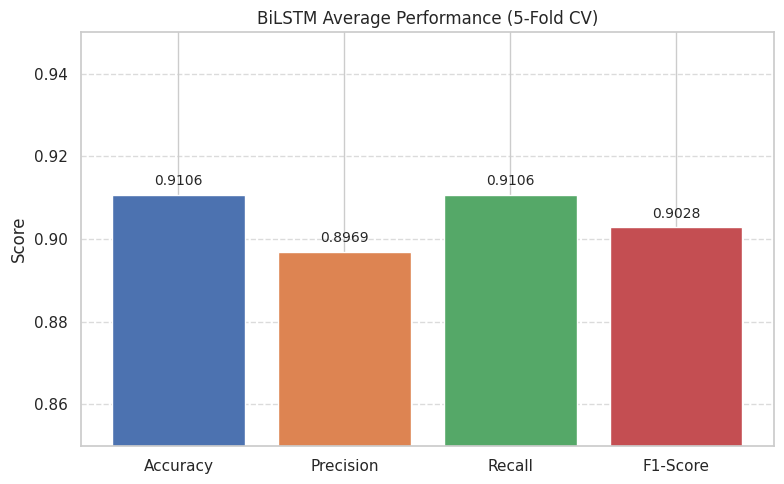

In [ ]:
import matplotlib.pyplot as plt

# BiLSTM average scores from your results
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [0.9106, 0.8969, 0.9106, 0.9028]

# Define matching color scheme (same as your previous chart)
colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52']

# Plot
plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores, color=colors)

# Annotate bars with values
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.4f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 5),
                 textcoords='offset points',
                 ha='center', va='bottom', fontsize=10)

# Styling
plt.ylim(0.85, 0.95)
plt.title("BiLSTM Average Performance (5-Fold CV)")
plt.ylabel("Score")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Show the chart
plt.show()

### Feature Engineering (Transformers : DistilBERT)


In [ ]:
# ✅ Clean short reviews
df = df[df['content'].str.split().str.len() > 2].reset_index(drop=True)

# ✅ Convert scores to labels
def score_to_label(score):
    if score <= 2:
        return 0  # Negative
    elif score == 3:
        return 1  # Neutral
    else:
        return 2  # Positive

df['label'] = df['score'].apply(score_to_label)

# ✅ Tokenize using DistilBERT (shorter = faster)
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
encoded = tokenizer(
    df['content'].tolist(),
    padding='max_length',
    truncation=True,
    max_length=64,
    return_tensors='pt'
)

input_ids = encoded['input_ids']
attention_masks = encoded['attention_mask']
labels = torch.tensor(df['label'].values)

# ✅ K-Fold Split
kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

## Train Transfomer Models

In [ ]:
# Storage for per-fold metrics
fold_accuracy = []
fold_precision = []
fold_recall = []
fold_f1 = []

epochs = 2

In [ ]:
for fold, (train_idx, val_idx) in enumerate(kf.split(input_ids, labels)):
    print(f"\n===== Fold {fold + 1} =====")

    # ✅ Create dataloaders
    train_ids, val_ids = input_ids[train_idx], input_ids[val_idx]
    train_masks, val_masks = attention_masks[train_idx], attention_masks[val_idx]
    train_labels, val_labels = labels[train_idx], labels[val_idx]

    train_data = TensorDataset(train_ids, train_masks, train_labels)
    val_data = TensorDataset(val_ids, val_masks, val_labels)

    train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=16)

    # ✅ Model and optimizer
    model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=3)
    model.to(device)

    # ✅ Safe class weight calculation
    class_weights = compute_class_weight('balanced', classes=np.array([0, 1, 2]), y=train_labels.cpu().numpy())
    loss_fn = torch.nn.CrossEntropyLoss(weight=torch.tensor(class_weights, dtype=torch.float).to(device))

    optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
    total_steps = len(train_loader) * epochs
    lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # ✅ Training
    for epoch in range(epochs):
        print(f"\nEpoch {epoch + 1}/{epochs}")
        model.train()
        for batch in train_loader:
            b_ids, b_masks, b_labels = [x.to(device) for x in batch]
            outputs = model(input_ids=b_ids, attention_mask=b_masks)
            loss = loss_fn(outputs.logits, b_labels)
            loss.backward()
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

    # ✅ Evaluation
    model.eval()
    predictions, true_labels = [], []
    with torch.no_grad():
        for batch in val_loader:
            b_ids, b_masks, b_labels = [x.to(device) for x in batch]
            logits = model(input_ids=b_ids, attention_mask=b_masks).logits
            preds = torch.argmax(logits, axis=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(b_labels.cpu().numpy())

    # ✅ Metrics
    acc = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted', zero_division=0)

    fold_accuracy.append(acc)
    fold_precision.append(precision)
    fold_recall.append(recall)
    fold_f1.append(f1)

    print(f"\nFold {fold + 1} Metrics:")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall   : {recall:.4f}")
    print(f"F1-Score : {f1:.4f}")
    print(classification_report(true_labels, predictions, target_names=["Negative", "Neutral", "Positive"]))


===== Fold 1 =====


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2

Epoch 2/2

Fold 1 Metrics:
Accuracy : 0.8483
Precision: 0.9000
Recall   : 0.8483
F1-Score : 0.8713
              precision    recall  f1-score   support

    Negative       0.86      0.84      0.85       919
     Neutral       0.12      0.31      0.17        94
    Positive       0.98      0.89      0.93      1327

    accuracy                           0.85      2340
   macro avg       0.66      0.68      0.65      2340
weighted avg       0.90      0.85      0.87      2340


===== Fold 2 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2

Epoch 2/2

Fold 2 Metrics:
Accuracy : 0.8593
Precision: 0.9111
Recall   : 0.8593
F1-Score : 0.8819
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.87       920
     Neutral       0.15      0.40      0.22        93
    Positive       0.98      0.90      0.94      1326

    accuracy                           0.86      2339
   macro avg       0.67      0.71      0.67      2339
weighted avg       0.91      0.86      0.88      2339


===== Fold 3 =====


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Epoch 1/2

Epoch 2/2

Fold 3 Metrics:
Accuracy : 0.8658
Precision: 0.8917
Recall   : 0.8658
F1-Score : 0.8774
              precision    recall  f1-score   support

    Negative       0.89      0.83      0.86       920
     Neutral       0.17      0.32      0.22        93
    Positive       0.95      0.93      0.94      1326

    accuracy                           0.87      2339
   macro avg       0.67      0.69      0.67      2339
weighted avg       0.89      0.87      0.88      2339



In [ ]:
# ✅ Summary
print("\n=== Final K-Fold Summary ===")
for i in range(len(fold_accuracy)):
    print(f"Fold {i+1}: Acc={fold_accuracy[i]:.4f}, Prec={fold_precision[i]:.4f}, Rec={fold_recall[i]:.4f}, F1={fold_f1[i]:.4f}")

print(f"\nAverage Accuracy : {np.mean(fold_accuracy):.4f}")
print(f"Average Precision: {np.mean(fold_precision):.4f}")
print(f"Average Recall   : {np.mean(fold_recall):.4f}")
print(f"Average F1-Score : {np.mean(fold_f1):.4f}")


=== Final K-Fold Summary ===
Fold 1: Acc=0.8483, Prec=0.9000, Rec=0.8483, F1=0.8713
Fold 2: Acc=0.8593, Prec=0.9111, Rec=0.8593, F1=0.8819
Fold 3: Acc=0.8658, Prec=0.8917, Rec=0.8658, F1=0.8774

Average Accuracy : 0.8578
Average Precision: 0.9009
Average Recall   : 0.8578
Average F1-Score : 0.8768


/tmp/ipython-input-22-1442184166.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(final_scores.keys()), y=list(final_scores.values()), palette="colorblind")


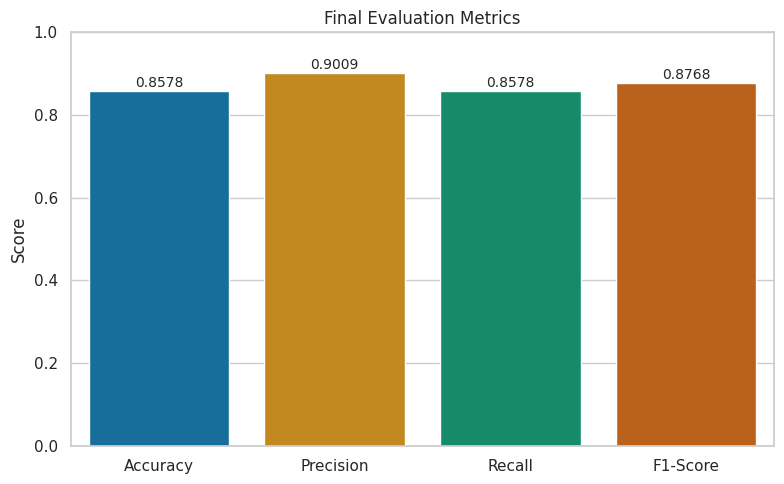

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Replace these with your actual final metrics
final_scores = {
    "Accuracy": 0.8578,
    "Precision": 0.9009,
    "Recall": 0.8578,
    "F1-Score": 0.8768
}

# Plot
plt.figure(figsize=(8, 5))
sns.barplot(x=list(final_scores.keys()), y=list(final_scores.values()), palette="colorblind")

# Annotate values
for i, (label, score) in enumerate(final_scores.items()):
    plt.text(i, score + 0.002, f"{score:.4f}", ha='center', va='bottom', fontsize=10)

# Set axis and title
plt.ylim(0, 1.0)
plt.ylabel("Score")
plt.title("Final Evaluation Metrics")
plt.tight_layout()
plt.show()


#### Model Evaluation Comparison

This section presents the comparison of different models used for sentiment classification of Uber reviews. The models include both traditional machine learning and deep learning approaches. Each model is evaluated using four performance metrics: Accuracy, Precision, Recall, and F1-Score.

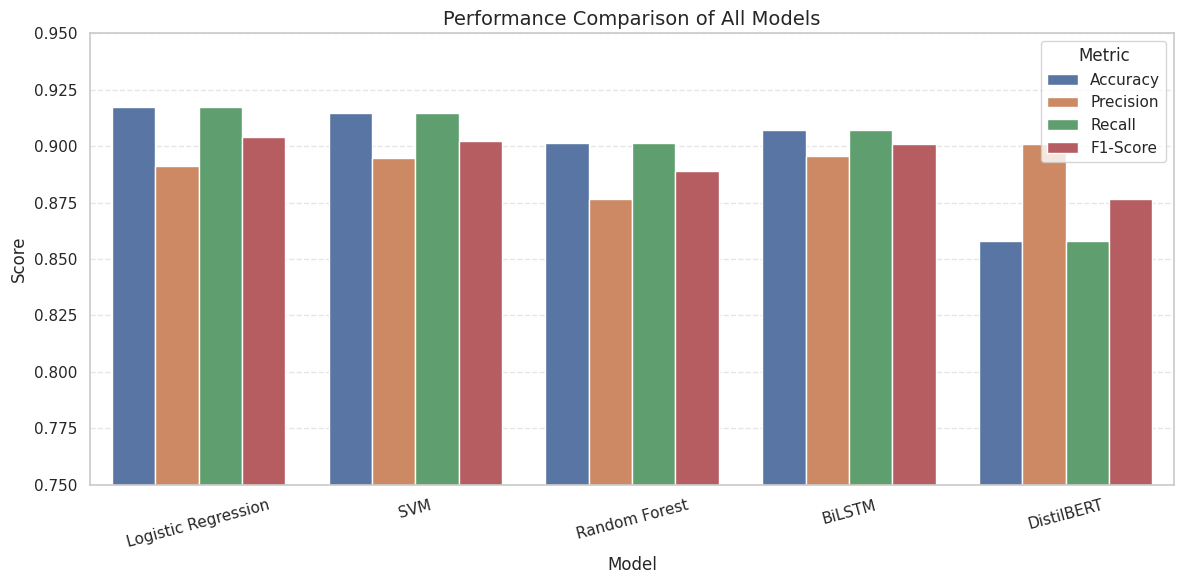

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all final results
results_combined = pd.DataFrame([
    {"Model": "Logistic Regression", "Accuracy": 0.9173, "Precision": 0.8914, "Recall": 0.9173, "F1-Score": 0.9041},
    {"Model": "SVM",                "Accuracy": 0.9145, "Precision": 0.8947, "Recall": 0.9145, "F1-Score": 0.9025},
    {"Model": "Random Forest",      "Accuracy": 0.9016, "Precision": 0.8768, "Recall": 0.9016, "F1-Score": 0.8890},
    {"Model": "BiLSTM",             "Accuracy": 0.9072, "Precision": 0.8955, "Recall": 0.9072, "F1-Score": 0.9008},
    {"Model": "DistilBERT",         "Accuracy": 0.8578,"Precision": 0.9009,"Recall": 0.8578,"F1-Score": 0.8768}
])

# Melt for seaborn
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
results_melted = results_combined.melt(
    id_vars="Model",
    value_vars=metrics,
    var_name="Metric",
    value_name="Score"
)

# Define custom colors per metric (match your reference image) colors = ['#4c72b0', '#dd8452', '#55a868', '#c44e52']
metric_palette = {
    "Accuracy": "#4c72b0",     # Blue
    "Precision": "#dd8452",    # Yellow-brown (like DistilBERT bar)
    "Recall": "#55a868",       # Green
    "F1-Score": "#c44e52"      # Orange-brown
}

# Plot
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
sns.barplot(
    data=results_melted,
    x="Model", y="Score", hue="Metric",
    palette=metric_palette
)

# Styling
plt.title("Performance Comparison of All Models", fontsize=14)
plt.ylim(0.75, 0.95)
plt.xticks(rotation=15)
plt.ylabel("Score")
plt.xlabel("Model")
plt.legend(title="Metric", loc='upper right')  # Top-right legend
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

### Keyword Extraction by Sentiment using WordCloud

This code visualizes the most frequent words in each sentiment category (negative, neutral, positive) using WordClouds. It helps identify common praise or complaints at a glance, providing valuable business insights.

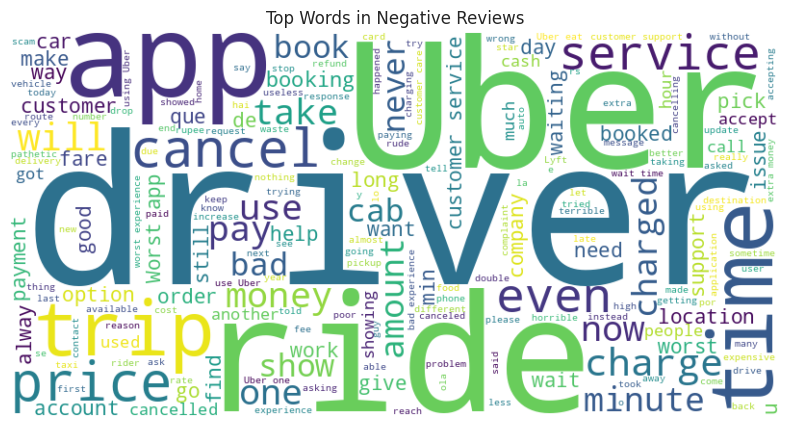

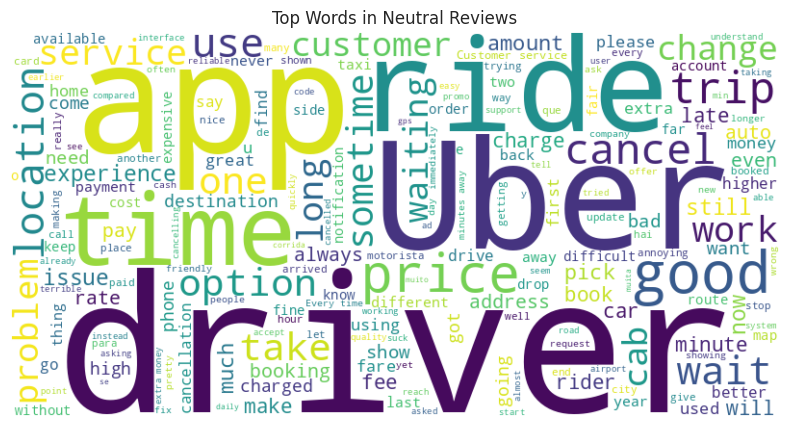

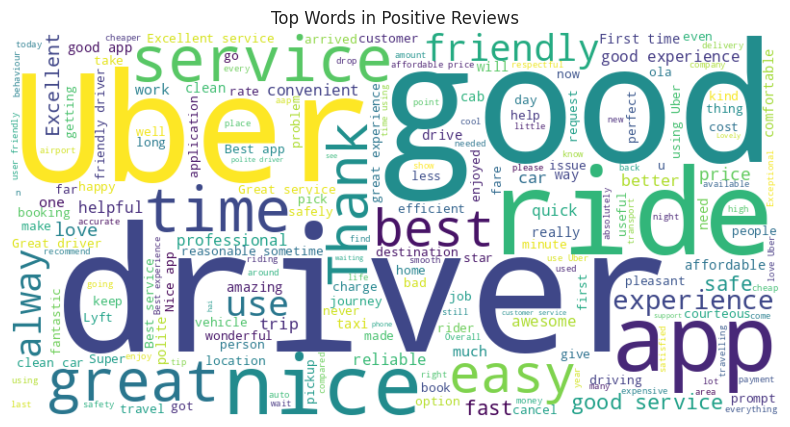

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Group by sentiment label
for label, sentiment in zip([0, 1, 2], ["Negative", "Neutral", "Positive"]):
    text = " ".join(df[df['label'] == label]['content'])
    wc = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Top Words in {sentiment} Reviews")
    plt.show()

### Top Bigrams in Negative Reviews

This code finds the most common two-word combinations (bigrams) in negative reviews. It helps identify recurring issues (e.g., "long wait", "app crash") that customers complain about, which can guide improvements.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter
from nltk.util import ngrams
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

# Extract negative reviews only
neg_reviews = df[df['label'] == 0]['content']

# Vectorize and extract bigrams
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
X = vectorizer.fit_transform(neg_reviews)
bigrams_freq = zip(vectorizer.get_feature_names_out(), X.toarray().sum(axis=0))
sorted_bigrams = sorted(bigrams_freq, key=lambda x: x[1], reverse=True)[:10]

print("🔍 Top 10 bigrams in negative reviews:")
for bigram, freq in sorted_bigrams:
    print(f"{bigram}: {freq}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


🔍 Top 10 bigrams in negative reviews:
worst app: 128
customer service: 119
customer support: 93
cancel ride: 75
bad experience: 61
use uber: 59
uber app: 58
worst experience: 55
uber eats: 51
using uber: 49
